Last updated: 22 Jul 2023
<div align='center'>
<h1>Applying Semi-AutoML for Vessel Traffic Flow Prediction: Case Studies of Two Ports</h1h1>
</div>


---



This notebook presents an exploration of semi-Automated Machine Learning (AutoML) techniques for vessel traffic flow prediction. The study is applied on two ports data: Mohammedia and Los Angeles.


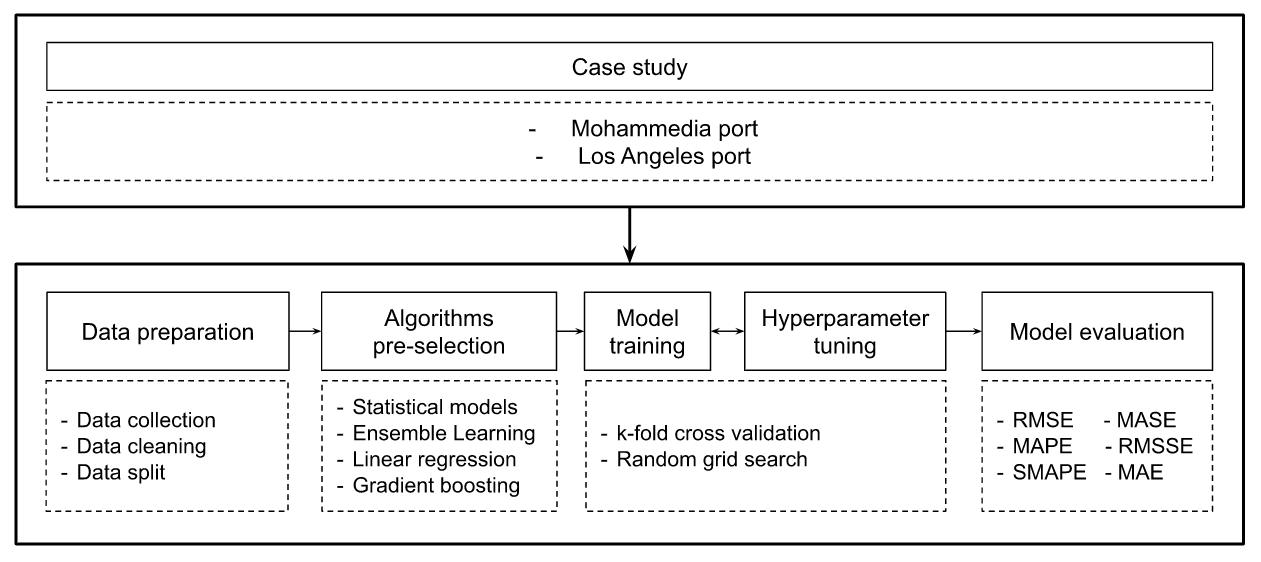

The workflow used in this study begins with dataset selection for the comparative analyses: Mohammedia port and Los Angeles port. Data preparation follows, involving examination, processing, and aggregation of selected data. The datasets are then divided into training, testing, and validation sets for model training, unbiased evaluation, and validation. Pre-selected algorithms are evaluated using AutoML provided by Pycaret framwork to identify the top performers models. These selected algorithms are then fine-tuned to improve their performance and evaluated using different metrics (RMSE, MAPE...).

## Citation
TODO

## Setup

### Install packages
To execute this notebook successfully, PyCaret must be installed using Python's pip package manager. All other dependencies are automatically provided in the Colab environment.

In [ ]:
!pip install pycaret===3.0.0

### Import the necessary packages

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from google.colab import drive
from pycaret.time_series import TSForecastingExperiment

### Define global settings by case study

In [ ]:
global_fig_settings = {
  "width": 600,
  "height": 400,
  "template": "simple_white",
}

settings = dict(
  mohammedia={
    'data_source_path': "/content/drive/My Drive/Colab Notebooks/mohammedia (length 100-180_weekly_2017-2022).csv",
    'seen_unseen_date_split': '2022-01-01',
    'train_test_percentage_split': 0.85,
    'metrics': ["RMSE", "MASE", "RMSSE", "MAE", "MAPE", "SMAPE", "TT (Sec)"],
    'metric_objective': 'RMSE',
    'forecast_horizon': 16,
    'initial_fold': 5,
    'time_period': 'weeks',
    'time_period_refrence': 'W',
    'figure_reference': "(a)",
  },
  los_angeles={
    'data_source_path': "/content/drive/My Drive/Colab Notebooks/los angeles (january_2010-2014).csv",
    'seen_unseen_date_split': '2014-01-20',
    'train_test_percentage_split': 0.99, # The high split value is attributed to the inclusion of "zero" values, whereas the actual split value is 0.9
    'metrics': ["RMSE", "MASE", "RMSSE", "MAE", "MAPE", "SMAPE", "TT (Sec)"],
    'metric_objective': 'RMSE',
    'forecast_horizon': 11,
    'initial_fold': 5,
    'time_period': 'days',
    'time_period_refrence': 'd',
    'figure_reference': "(b)",
  },
)

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define helper functions
These functions are the core of the code and shared between both case studies.

Data selection

In [ ]:
def plot_time_series(df, study_case, time_period):
  fig = go.Figure()
  fig.add_trace(
    go.Scatter(
      x=df.index,
      y=df['vessels'],
      mode='lines',
    )
  )
  fig.update_layout(
    title_text=settings[study_case]['figure_reference'],
    height=400, width=800,
    legend=dict(
      x=0.01,
      y=1,
      traceorder='normal',
      bordercolor='Black',
      borderwidth=1,
      font=dict(size=14),
    ),
    xaxis=dict(
      title=f'date ({time_period})',
      tickfont=dict(size=14),
      title_font=dict(size=16),
    ),
    yaxis=dict(
      title='Number of vessels',
      tickfont=dict(size=14),
      title_font=dict(size=16),
    ),
  )
  fig.show()

def data_selection(settings, study_case):
  df = pd.read_csv(settings[study_case]['data_source_path'])
  df['date'] = pd.to_datetime(df['date'])
  df = df.groupby(pd.Grouper(key='date', freq=settings[study_case]['time_period_refrence'])).agg({'vessels': 'sum'})

  # display data sample
  display(df)

  # display time series graph
  plot_time_series(df, study_case, settings[study_case]['time_period'])

  return df



Data preparation

In [ ]:
def split_data_by_date(data, split_date):
	df1 = data[data.index <= split_date]
	df2 = data[data.index >  split_date]
	return df1, df2

def split_data_by_percent(data, percentage):
	rows = int(len(data) * percentage)
	df1 = data[:rows]
	df2 = data[rows:]
	return df1, df2


def plot_time_series_by_set(train_df, test_df, unseen_df, study_case, time_period, add_annotations=True):
  fig = go.Figure()
  fig.add_trace(
    go.Scatter(
      x=train_df.index,
      y=train_df['vessels'],
      mode='lines',
      name='Training set'
    )
  )
  fig.add_trace(
    go.Scatter(
      x=test_df.index,
      y=test_df['vessels'],
      mode='lines',
      name='Testing set'
    )
  )
  fig.add_trace(
    go.Scatter(
      x=unseen_df.index,
      y=unseen_df['vessels'],
      mode='lines',
      name='Validation set'
    )
  )

  # Add annotations with arrows for each line graph
  if add_annotations:
    data_length = len(train_df.index) + len(test_df.index) + len(unseen_df.index)
    annotations = []
    for trace in fig.data:
        x_start = trace.x[-1]
        x_end = trace.x[0]
        y = max(trace.y)
        text = f'{trace.name} ({len(trace.x)}- {round(100 * len(trace.x) / data_length, 2)}%)'

        # Add arrow annotation
        annotations.append(
            dict(
                x=x_start,
                y=y,
                xref='x',
                yref='y',
                text=text,
                showarrow=True,
              # arrowhead=2,
              axref='x',
              ayref='y',
              ax=x_end,
              ay=y,
              arrowcolor='black',
              standoff=10,
              font=dict(size=12),
              textangle=0,
              xanchor='left',
              yanchor='bottom',
              align='center',
              arrowhead=3,
            )
        )
    fig.update_layout(annotations=annotations)
  fig.update_layout(
    title_text=settings[study_case]['figure_reference'],
    height=350, width=1200,
    showlegend=False,
    legend=dict(
      x=0.01,
      y=1,
      traceorder='normal',
      bordercolor='Black',
      borderwidth=1,
      font=dict(size=14),
    ),
    xaxis=dict(
      title=f'date ({time_period})',
      tickfont=dict(size=14),
      title_font=dict(size=16),
    ),
    yaxis=dict(
      title='Number of vessels',
      tickfont=dict(size=14),
      title_font=dict(size=16),
    ),
  )
  fig.show()

def data_preparation(df, study_case, settings):
  # split the data to seen (train & test sets) and unseen (validation set)
  seen_df, unseen_df = split_data_by_date(df, settings[study_case]['seen_unseen_date_split'])

  # split seen dataframe to train and test
  train_df, test_df = split_data_by_percent(seen_df, settings[study_case]['train_test_percentage_split'])

  # display the graph
  plot_time_series_by_set(train_df, test_df, unseen_df, study_case, settings[study_case]['time_period'], add_annotations=True)

  return seen_df, unseen_df, train_df, test_df

Models pre-selection using AutoML

In [ ]:
def print_title(text):
  print('\n\033[94m' + '------------------------------------' + '\033[0m')
  print('\033[94m' + text + '\033[0m')
  print('\033[94m' + '------------------------------------' + '\033[0m\n')

def print_subtitle(text):
  print('\n\033[91m' + text + '\033[0m\n')

def automl_phase(df, test_df, unseen_df, study_case):
    print_title("Comparing models using AutoML")
    print_subtitle("- AutoML setup")
    ts = TSForecastingExperiment()
    session = ts.setup(
        df,
        target='vessels',
        fh=settings[study_case]['forecast_horizon'],
        fold=settings[study_case]['initial_fold'],
        fig_kwargs=global_fig_settings,
        numeric_imputation_target=0,
        numeric_imputation_exogenous=0,
        experiment_name='session_1',
        session_id=123,
        # feature_selection = True,
        # feature_selection_method = 'boruta',
        # remove_outliers=True,
        # normalize=True,
        # transform_target=True,
    )

    print_subtitle("- Pre-selected models comparaison")
    all_models = session.compare_models(
        n_select=14,
        sort=settings[study_case]['metric_objective'],
        include=[
            # ensemble learning
            'rf_cds_dt',
            'et_cds_dt',
            'ada_cds_dt',
            # linear regression
            'lasso_cds_dt',
            'llar_cds_dt',
            'lar_cds_dt',
            'ridge_cds_dt',
            'en_cds_dt',
            # gradient boosting
            'gbr_cds_dt',
            'catboost_cds_dt',
            'lightgbm_cds_dt',
            'xgboost_cds_dt',
            # classification and regressionees trees
            'dt_cds_dt',
            'knn_cds_dt',
        ]
    )
    all_models_results = session.pull()
    # simplified labels
    all_models_results["Model name"] = all_models_results["Model"].apply(lambda x: x.replace(" w/ Cond. Deseasonalize & Detrending", ""))
    # all_models_results = all_models_results[~all_models_results["Model"].isin(["Linear", "Least Angular Regressor"])]

    # generate metrics figure
    print_subtitle('- Comparative evaluation metrics for pre-selected models')
    fig = make_subplots(rows=len(settings[study_case]['metrics']), cols=1, shared_xaxes=True, vertical_spacing=0.03)
    for index, metric in enumerate(settings[study_case]['metrics']):
        fig.add_trace(
            go.Scatter(x=all_models_results["Model name"], y=all_models_results[metric], mode='lines+markers', name=metric),
            row=index+1, col=1
        )
        # Update subplot titles
        fig.update_yaxes(title_text=metric, row=index+1, col=1)

    fig.update_layout(
        height=1000, width=600,
        title_text=settings[study_case]['figure_reference'],
        xaxis=dict(
            tickfont=dict(size=14),
            title_font=dict(size=16),
            ),
        yaxis=dict(
            tickfont=dict(size=14),
            title_font=dict(size=16),
        ),
    )
    fig.show()

    # generate future forecast
    print_subtitle('- Actual vs prediction results of the vessel traffic flow')
    fig = go.Figure()
    for index, (model_ref, row) in enumerate(all_models_results.iterrows()):
        length = len(test_df)
        dates = pd.Series(test_df.index)
        forecast_df = session.predict_model(all_models[index], fh=length)

        if index == 0:
            # add actual plot of the original data
            fig.add_trace(
                go.Scatter(
                    x=dates,
                    y=test_df['vessels'],
                    # y=df.iloc[-settings[study_case]['forecast_horizon']:]['vessels'],
                    mode='lines+markers',
                    name='actual'
                )
            )

        fig.add_trace(
            go.Scatter(
                x=dates,
                y=forecast_df['y_pred'],
                mode='lines+markers',
                name=row['Model name']
            )
        )
    fig.update_layout(
        height=550, width=1400,
        title_text=settings[study_case]['figure_reference'],
        legend=dict(
            traceorder='normal',
            bordercolor='Black',
            borderwidth=1,
            font=dict(size=14),
            ),
        xaxis=dict(
            title='date (weeks)' if study_case=='mohammedia' else 'date (days)',
            tickfont=dict(size=14),
            title_font=dict(size=16),
            ),
        yaxis=dict(
            title="Number of vessels",
            tickfont=dict(size=14),
            title_font=dict(size=16),
        ),
    )
    fig.show()
    return session, all_models, all_models_results



Hyperparameter tuning

In [ ]:
def hyperparameter_tuning_phase(df, test_df, unseen_df, study_case, session, all_models, all_models_results):
    print_title("Manually train the best 2 models")
    best_fold_df = pd.DataFrame()
    tuned_model_list = []
    for index, (model_ref, row) in enumerate(all_models_results.iloc[:2].iterrows()):
        print_subtitle(f'>> Training {row["Model name"]} model')
        folds = [1, 3, 5, 7, 9, 11]
        for f in folds:
            print_subtitle(f'Using k = {f} ...')
            model = session.create_model(model_ref, cross_validation=True, fold=f)
            model_row = session.pull().loc['Mean']
            model_row['Model name'] = row["Model name"]
            model_row['fold'] = f
            model_df = pd.DataFrame(model_row).T
            best_fold_df = pd.concat([best_fold_df, model_df])

        best_fold_df = best_fold_df.reset_index(drop=True)
        best_fold_df['RMSE'] = best_fold_df['RMSE'].astype(float)
        best_k_value_row = best_fold_df.loc[
            best_fold_df[best_fold_df['Model name'] == row["Model name"]].groupby('Model name')['RMSE'].idxmin()
        ]

        print_subtitle(f'Best k value for {row["Model name"]} model is k = {best_k_value_row["fold"].iloc[0]} with RMSE = {best_k_value_row["RMSE"].iloc[0]}')
        display(best_k_value_row)

        print_subtitle(f'>> Hyperparameter tuning of {row["Model name"]} model using the best k value = {best_k_value_row["fold"].iloc[0]}')

        tuned_model = session.tune_model(model, n_iter=5, optimize=settings[study_case]['metric_objective'], fold=best_k_value_row['fold'].iloc[0], verbose=False)
        tuned_model_list.append({"model": tuned_model, "name": row["Model name"]})

        print_subtitle(f'{row["Model name"]} model parameters')
        model_1_params = tuned_model.get_params()
        print(model_1_params['regressor'].get_params())
        print_subtitle('--------------')

    # RMSE by k-fold results
    print_subtitle('- RMSE based on different k values applied on the test set')
    model_names = best_fold_df['Model name'].unique()
    fig = go.Figure()
    for model_name in model_names:
        model_df = best_fold_df[best_fold_df['Model name'] == model_name]
        fig.add_trace(go.Scatter(
            x=model_df['fold'],
            y=model_df['RMSE'],
            mode='lines+markers',
            name=model_name
        ))
    fig.update_layout(
        title_text=settings[study_case]['figure_reference'],
        height=400, width=800,
        legend=dict(
            traceorder='normal',
            bordercolor='Black',
            borderwidth=1,
            font=dict(size=14),
            ),
        xaxis=dict(
            title='K value',
            tickfont=dict(size=14),
            title_font=dict(size=16),
            ),
        yaxis=dict(
            title='RMSE',
            tickfont=dict(size=14),
            title_font=dict(size=16),
        ),
    )
    fig.show()

    # generate future forecast using tuned models (validation set)
    print_subtitle('- Prediction results of the vessel traffic flow after hyperparameter tuning applied on test & validation sets')
    fig = go.Figure()
    for index, tuned_model in enumerate(tuned_model_list):
        length = len(test_df)+len(unseen_df)
        dates = pd.concat([pd.Series(test_df.index), pd.Series(unseen_df.index)])
        forecast_df = session.predict_model(tuned_model['model'], fh=length)
        # # Convert Period to
        # forecast_df.index = forecast_df.index.astype(str)

        if index == 0:
            # add actual plot of the original data
            fig.add_trace(
                go.Scatter(
                    x=dates,
                    # x=forecast_df.index.str[:10],
                    y=pd.concat([test_df['vessels'], unseen_df['vessels']]),
                    # y=df.iloc[-settings[study_case]['forecast_horizon']:]['vessels'],
                    mode='lines+markers',
                    name='actual'
                )
            )

        fig.add_trace(
            go.Scatter(
                x=dates,
                # x=forecast_df.index.str[:10],
                y=forecast_df['y_pred'],
                mode='lines+markers',
                name=tuned_model['name']
            )
        )
    fig.update_layout(
        height=400, width=1200,
        title_text=settings[study_case]['figure_reference'],
        legend=dict(
            traceorder='normal',
            # bgcolor='LightSteelBlue',
            bordercolor='Black',
            borderwidth=1,
            font=dict(size=14),
            ),
        xaxis=dict(
            title='date (weeks)' if study_case=='mohammedia' else 'date (days)',
            tickfont=dict(size=14),
            title_font=dict(size=16),
            ),
        yaxis=dict(
            title="Number of vessels",
            tickfont=dict(size=14),
            title_font=dict(size=16),
        ),
    )
    fig.show()



# Case study: Mohammedia
The case study reference is selected, either `mohammedia` or `los_angeles`. In this case the first was selected.

In [ ]:
study_case = "mohammedia"

## Data selection
The relevant data is extracted from a CSV file containing time series information.

In [ ]:
df = data_selection(settings, study_case)

,vessels
date,
2017-01-01,1.0
2017-01-08,4.0
2017-01-15,2.0
2017-01-22,5.0
2017-01-29,7.0
...,...
2022-05-01,5.0
2022-05-08,7.0
2022-05-15,3.0


## Data preparation
The data processing phase is not presented here, assuming that the data we access is already preprocessed and aggregated as required. The data is divided into training, testing and validation sets.

**Note:** *The percentage of data shown in the graph represents the split of the entire dataset, including the validation set. However, when considering only the training data, the split percentage becomes 85% for the training set and 15% for the test set.*

In [ ]:
seen_df, unseen_df, train_df, test_df = data_preparation(df, study_case, settings)

## Models pre-selection using AutoML
12 models from 3 different groups are evaluated with AutoML. The pre-selected models are:
* **Ensemble learning**
  * Random Forest
  * Extra Trees
  * Adaptive Boosting (AdaBoost).
* **Linear regression**
  * Least Absolute Shrinkage and Selection Operator(Lasso)
  * Least Angle Regression (LARS)
  * Ridge
  * Lasso Least Angle Regression(LLAR)
  * Elastic Net
* **Gradient boosting**
  * Gradient Boosting for Regression (GBR)
  * Categorical Boosting (CatBoost)
  * Light Gradient Boosting Machine (LightGBM)
  * Extreme Gradient Boosting (XGBoost)


In [ ]:
session, all_models, all_models_results = automl_phase(seen_df, test_df, unseen_df, study_case)


------------------------------------
Comparing models using AutoML
------------------------------------


- AutoML setup



,Description,Value
0,session_id,123
1,Target,vessels
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(261, 1)"
5,Transformed data shape,"(261, 1)"
6,Transformed train set shape,"(245, 1)"
7,Transformed test set shape,"(16, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter



- Pre-selected models comparaison



,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,1.0072,0.9611,2.0299,2.4618,0.4360,0.3537,-0.4037,1.9620
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,1.0192,0.9642,2.0553,2.4720,0.4555,0.3579,-0.4057,5.6600
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,1.0383,0.9818,2.0912,2.5132,0.4511,0.3692,-0.4636,2.9080
catboost_cds_dt,CatBoost Regressor w/ Cond. Deseasonalize & Detrending,1.0627,0.9979,2.1402,2.5559,0.4731,0.3736,-0.5000,8.9320
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.0646,1.0160,2.1442,2.6027,0.4562,0.3814,-0.5622,1.5360
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.1002,1.0246,2.2162,2.6240,0.4601,0.3906,-0.6164,1.0700
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.1002,1.0246,2.2162,2.6240,0.4601,0.3906,-0.6164,0.8240
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.0952,1.0258,2.2061,2.6274,0.4626,0.3875,-0.6131,1.1160
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.0851,1.0252,2.1896,2.6292,0.4704,0.3809,-0.5982,0.8900
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,1.0506,1.0432,2.1156,2.6718,0.4531,0.3790,-0.6615,0.9780


Processing:   0%|          | 0/74 [00:00<?, ?it/s]


- Comparative evaluation metrics for pre-selected models




- Actual vs prediction results of the vessel traffic flow



## Hyperparameter tuning
During this stage, the top two best-performing models based on the RMSE value are chosen for fine-tuning.


In [ ]:
hyperparameter_tuning_phase(df, test_df, unseen_df, study_case, session, all_models, all_models_results)


------------------------------------
Manually train the best 2 models
------------------------------------


>> Training AdaBoost model


Using k = 1 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2021-05-10/2021-05-16,1.0164,0.9096,2.1133,2.4235,0.7056,0.4041,-0.0214
Mean,NaT,1.0164,0.9096,2.1133,2.4235,0.7056,0.4041,-0.0214
SD,NaT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 3 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2020-09-28/2020-10-04,0.7424,0.7329,1.5373,1.9294,0.2363,0.2348,-0.1042
1,2021-01-18/2021-01-24,0.8478,0.8795,1.7548,2.3262,0.4326,0.3002,-0.3581
2,2021-05-10/2021-05-16,1.0164,0.9096,2.1133,2.4235,0.7056,0.4041,-0.0214
Mean,NaT,0.8689,0.8407,1.8018,2.2263,0.4581,0.3130,-0.1612
SD,NaT,0.1128,0.0772,0.2375,0.2137,0.1924,0.0697,0.1432


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 5 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2020-02-17/2020-02-23,1.4218,1.3565,2.6890,3.2187,0.4971,0.4937,-0.8430
1,2020-06-08/2020-06-14,1.0078,0.9270,2.0548,2.4114,0.3083,0.3358,-0.6916
2,2020-09-28/2020-10-04,0.7424,0.7329,1.5373,1.9294,0.2363,0.2348,-0.1042
3,2021-01-18/2021-01-24,0.8478,0.8795,1.7548,2.3262,0.4326,0.3002,-0.3581
4,2021-05-10/2021-05-16,1.0164,0.9096,2.1133,2.4235,0.7056,0.4041,-0.0214
Mean,NaT,1.0072,0.9611,2.0299,2.4618,0.4360,0.3537,-0.4037
SD,NaT,0.2313,0.2092,0.3900,0.4192,0.1629,0.0888,0.3206


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 7 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-07-08/2019-07-14,0.9548,0.9768,1.6934,2.1800,0.5836,0.4627,-0.1698
1,2019-10-28/2019-11-03,1.5088,1.4821,2.6961,3.3411,0.5233,0.5678,-0.4353
2,2020-02-17/2020-02-23,1.4218,1.3565,2.6890,3.2187,0.4971,0.4937,-0.8430
3,2020-06-08/2020-06-14,1.0078,0.9270,2.0548,2.4114,0.3083,0.3358,-0.6916
4,2020-09-28/2020-10-04,0.7424,0.7329,1.5373,1.9294,0.2363,0.2348,-0.1042
5,2021-01-18/2021-01-24,0.8478,0.8795,1.7548,2.3262,0.4326,0.3002,-0.3581
6,2021-05-10/2021-05-16,1.0164,0.9096,2.1133,2.4235,0.7056,0.4041,-0.0214
Mean,NaT,1.0714,1.0378,2.0770,2.5472,0.4695,0.3999,-0.3748
SD,NaT,0.2654,0.2534,0.4313,0.4900,0.1484,0.1084,0.2838


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 9 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2018-11-26/2018-12-02,0.7216,0.7692,1.2871,1.7060,1091136920096434.7500,0.4330,-0.1715
1,2019-03-18/2019-03-24,0.6690,0.6615,1.2042,1.4955,890155281122755.7500,0.4512,0.0690
2,2019-07-08/2019-07-14,0.9548,0.9768,1.6934,2.1800,0.5836,0.4627,-0.1698
3,2019-10-28/2019-11-03,1.5088,1.4821,2.6961,3.3411,0.5233,0.5678,-0.4353
4,2020-02-17/2020-02-23,1.4218,1.3565,2.6890,3.2187,0.4971,0.4937,-0.8430
5,2020-06-08/2020-06-14,1.0078,0.9270,2.0548,2.4114,0.3083,0.3358,-0.6916
6,2020-09-28/2020-10-04,0.7424,0.7329,1.5373,1.9294,0.2363,0.2348,-0.1042
7,2021-01-18/2021-01-24,0.8478,0.8795,1.7548,2.3262,0.4326,0.3002,-0.3581
8,2021-05-10/2021-05-16,1.0164,0.9096,2.1133,2.4235,0.7056,0.4041,-0.0214
Mean,NaT,0.9878,0.9661,1.8922,2.3368,220143577913243.7500,0.4092,-0.3029


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 11 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2018-04-16/2018-04-22,0.8002,0.8312,1.4480,1.7957,0.3463,0.3743,-0.6249
1,2018-08-06/2018-08-12,0.7658,0.8352,1.4259,1.8676,0.3619,0.3448,-0.1404
2,2018-11-26/2018-12-02,0.7216,0.7692,1.2871,1.7060,1091136920096434.7500,0.4330,-0.1715
3,2019-03-18/2019-03-24,0.6690,0.6615,1.2042,1.4955,890155281122755.7500,0.4512,0.0690
4,2019-07-08/2019-07-14,0.9548,0.9768,1.6934,2.1800,0.5836,0.4627,-0.1698
5,2019-10-28/2019-11-03,1.5088,1.4821,2.6961,3.3411,0.5233,0.5678,-0.4353
6,2020-02-17/2020-02-23,1.4218,1.3565,2.6890,3.2187,0.4971,0.4937,-0.8430
7,2020-06-08/2020-06-14,1.0078,0.9270,2.0548,2.4114,0.3083,0.3358,-0.6916
8,2020-09-28/2020-10-04,0.7424,0.7329,1.5373,1.9294,0.2363,0.2348,-0.1042
9,2021-01-18/2021-01-24,0.8478,0.8795,1.7548,2.3262,0.4326,0.3002,-0.3581


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Best k value for AdaBoost model is k = 3 with RMSE = 2.2263



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,Model name,fold
1,NaT,0.8689,0.8407,1.8018,2.2263,0.4581,0.313,-0.1612,AdaBoost,3



>> Hyperparameter tuning of AdaBoost model using the best k value = 3


AdaBoost model parameters

{'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': 123}

--------------


>> Training Random Forest model


Using k = 1 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2021-05-10/2021-05-16,1.0040,0.9376,2.0875,2.4982,0.7391,0.3961,-0.0854
Mean,NaT,1.0040,0.9376,2.0875,2.4982,0.7391,0.3961,-0.0854
SD,NaT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 3 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2020-09-28/2020-10-04,0.8738,0.8265,1.8092,2.1756,0.2708,0.2832,-0.4041
1,2021-01-18/2021-01-24,0.8688,0.8960,1.7982,2.3696,0.4341,0.3070,-0.4092
2,2021-05-10/2021-05-16,1.0040,0.9376,2.0875,2.4982,0.7391,0.3961,-0.0854
Mean,NaT,0.9155,0.8867,1.8983,2.3478,0.4813,0.3288,-0.2996
SD,NaT,0.0626,0.0459,0.1339,0.1326,0.1941,0.0486,0.1514


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 5 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2020-02-17/2020-02-23,1.4158,1.3302,2.6777,3.1564,0.5398,0.4936,-0.7724
1,2020-06-08/2020-06-14,0.9338,0.8305,1.9041,2.1603,0.2938,0.3096,-0.3576
2,2020-09-28/2020-10-04,0.8738,0.8265,1.8092,2.1756,0.2708,0.2832,-0.4041
3,2021-01-18/2021-01-24,0.8688,0.8960,1.7982,2.3696,0.4341,0.3070,-0.4092
4,2021-05-10/2021-05-16,1.0040,0.9376,2.0875,2.4982,0.7391,0.3961,-0.0854
Mean,NaT,1.0192,0.9642,2.0553,2.4720,0.4555,0.3579,-0.4057
SD,NaT,0.2042,0.1877,0.3280,0.3646,0.1722,0.0780,0.2188


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 7 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2019-07-08/2019-07-14,0.8958,0.9485,1.5889,2.1170,0.5146,0.4301,-0.1032
1,2019-10-28/2019-11-03,1.4606,1.5038,2.6099,3.3901,0.4892,0.5393,-0.4777
2,2020-02-17/2020-02-23,1.4158,1.3302,2.6777,3.1564,0.5398,0.4936,-0.7724
3,2020-06-08/2020-06-14,0.9338,0.8305,1.9041,2.1603,0.2938,0.3096,-0.3576
4,2020-09-28/2020-10-04,0.8738,0.8265,1.8092,2.1756,0.2708,0.2832,-0.4041
5,2021-01-18/2021-01-24,0.8688,0.8960,1.7982,2.3696,0.4341,0.3070,-0.4092
6,2021-05-10/2021-05-16,1.0040,0.9376,2.0875,2.4982,0.7391,0.3961,-0.0854
Mean,NaT,1.0647,1.0390,2.0679,2.5524,0.4688,0.3941,-0.3728
SD,NaT,0.2403,0.2474,0.3895,0.4763,0.1472,0.0920,0.2166


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 9 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2018-11-26/2018-12-02,0.7949,0.7694,1.4179,1.7063,970928342029618.6250,0.4731,-0.1719
1,2019-03-18/2019-03-24,0.6180,0.6649,1.1125,1.5031,1036138836391052.5000,0.4178,0.0595
2,2019-07-08/2019-07-14,0.8958,0.9485,1.5889,2.1170,0.5146,0.4301,-0.1032
3,2019-10-28/2019-11-03,1.4606,1.5038,2.6099,3.3901,0.4892,0.5393,-0.4777
4,2020-02-17/2020-02-23,1.4158,1.3302,2.6777,3.1564,0.5398,0.4936,-0.7724
5,2020-06-08/2020-06-14,0.9338,0.8305,1.9041,2.1603,0.2938,0.3096,-0.3576
6,2020-09-28/2020-10-04,0.8738,0.8265,1.8092,2.1756,0.2708,0.2832,-0.4041
7,2021-01-18/2021-01-24,0.8688,0.8960,1.7982,2.3696,0.4341,0.3070,-0.4092
8,2021-05-10/2021-05-16,1.0040,0.9376,2.0875,2.4982,0.7391,0.3961,-0.0854
Mean,NaT,0.9851,0.9675,1.8895,2.3418,223007464268963.8125,0.4055,-0.3024


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 11 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2018-04-16/2018-04-22,0.8061,0.7884,1.4587,1.7032,0.3674,0.3738,-0.4618
1,2018-08-06/2018-08-12,0.7335,0.8339,1.3658,1.8646,0.3393,0.3298,-0.1367
2,2018-11-26/2018-12-02,0.7949,0.7694,1.4179,1.7063,970928342029618.6250,0.4731,-0.1719
3,2019-03-18/2019-03-24,0.6180,0.6649,1.1125,1.5031,1036138836391052.5000,0.4178,0.0595
4,2019-07-08/2019-07-14,0.8958,0.9485,1.5889,2.1170,0.5146,0.4301,-0.1032
5,2019-10-28/2019-11-03,1.4606,1.5038,2.6099,3.3901,0.4892,0.5393,-0.4777
6,2020-02-17/2020-02-23,1.4158,1.3302,2.6777,3.1564,0.5398,0.4936,-0.7724
7,2020-06-08/2020-06-14,0.9338,0.8305,1.9041,2.1603,0.2938,0.3096,-0.3576
8,2020-09-28/2020-10-04,0.8738,0.8265,1.8092,2.1756,0.2708,0.2832,-0.4041
9,2021-01-18/2021-01-24,0.8688,0.8960,1.7982,2.3696,0.4341,0.3070,-0.4092


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Best k value for Random Forest model is k = 11 with RMSE = 2.2404



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,Model name,fold
11,NaT,0.9459,0.9391,1.8028,2.2404,182460652583697.71875,0.3958,-0.3019,Random Forest,11



>> Hyperparameter tuning of Random Forest model using the best k value = 11


Random Forest model parameters

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

--------------


- RMSE based on different k values applied on the test set




- Prediction results of the vessel traffic flow after hyperparameter tuning applied on test & validation sets



# Case study: Los Angeles
Following the same steps as we have done in the Mohammedia case study for Los Angeles data.

In [ ]:
study_case = "los_angeles"

## Data selection
**Note:** *Only the month of january is considered in this study.*

In [ ]:
df = data_selection(settings, study_case)

,vessels
date,
2010-01-01,97
2010-01-02,91
2010-01-03,106
2010-01-04,117
2010-01-05,107
...,...
2014-01-27,137
2014-01-28,142
2014-01-29,145


## Data preparation
**Note:** *As our analysis is limited to January, any missing data between January months is replaced with 0 and disregarded. This approach lead to inaccuracies in the graph depiction of the status bellow. The following are the actual values:*

- Training data (144 days) & Validation data (11 days)
- Train set (90%) & Test set (10%)


In [ ]:
seen_df, unseen_df, train_df, test_df = data_preparation(df, study_case, settings)

## Models pre-selection using AutoML

In [ ]:
session, all_models, all_models_results = automl_phase(seen_df, test_df, unseen_df, study_case)


------------------------------------
Comparing models using AutoML
------------------------------------


- AutoML setup



,Description,Value
0,session_id,123
1,Target,vessels
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(1481, 1)"
5,Transformed data shape,"(1481, 1)"
6,Transformed train set shape,"(1470, 1)"
7,Transformed test set shape,"(11, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter



- Pre-selected models comparaison



,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,12.6242,2.2399,23.0485,25.5593,194063953119093.0625,1.9999,-0.8726,0.8080
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,12.6336,2.2411,23.0660,25.5728,299973431217938.2500,1.9998,-0.8720,1.3960
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,12.6327,2.2413,23.0641,25.5746,287974629418152.7500,1.9998,-0.8721,0.6580
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,12.6462,2.2429,23.0892,25.5934,327765668704704.5625,2.0000,-0.8737,0.8260
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,12.6565,2.2458,23.1085,25.6273,402687187200999.2500,2.0000,-0.8739,0.6440
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,12.7434,2.2606,23.2709,25.7981,1373116794980781.0000,1.9990,-0.8689,0.3120
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,12.7434,2.2606,23.2709,25.7981,1373116794980790.5000,1.9990,-0.8689,0.3180
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,12.7442,2.2608,23.2724,25.7998,1381054906548371.5000,1.9990,-0.8689,0.6240
lar_cds_dt,Least Angular Regressor w/ Cond. Deseasonalize & Detrending,12.7480,2.2614,23.2794,25.8072,1416852305729536.2500,1.9990,-0.8688,0.4640
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,12.7480,2.2614,23.2794,25.8072,1416850488606243.7500,1.9990,-0.8688,0.5800


Processing:   0%|          | 0/74 [00:00<?, ?it/s]


- Comparative evaluation metrics for pre-selected models




- Actual vs prediction results of the vessel traffic flow



## Hyperparameter tuning

In [ ]:
hyperparameter_tuning_phase(df, test_df, unseen_df, study_case, session, all_models, all_models_results)


------------------------------------
Manually train the best 2 models
------------------------------------


>> Training Extra Trees model


Using k = 1 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2013-12-29,63.0065,11.1769,115.0291,127.5340,9807231474983.0449,1.9997,-4.3631
Mean,NaT,63.0065,11.1769,115.0291,127.5340,9807231474983.0449,1.9997,-4.3631
SD,NaT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 3 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2013-12-07,0.0258,0.0057,0.0479,0.0653,215650447251006.9062,2.0000,0.0000
1,2013-12-18,0.0278,0.0050,0.0512,0.0573,230447978480177.9062,2.0000,0.0000
2,2013-12-29,63.0065,11.1769,115.0291,127.5340,9807231474983.0449,1.9997,-4.3631
Mean,NaT,21.0201,3.7292,38.3761,42.5522,151968552402055.9688,1.9999,-1.4544
SD,NaT,29.6889,5.2663,54.2019,60.0912,100704593104178.5000,0.0002,2.0568


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 5 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2013-11-15,0.0341,0.0065,0.0643,0.0759,289377546235886.5625,2.0000,0.0000
1,2013-11-26,0.0267,0.0055,0.0500,0.0638,225036562153410.9688,2.0000,0.0000
2,2013-12-07,0.0258,0.0057,0.0479,0.0653,215650447251006.9062,2.0000,0.0000
3,2013-12-18,0.0278,0.0050,0.0512,0.0573,230447978480177.9062,2.0000,0.0000
4,2013-12-29,63.0065,11.1769,115.0291,127.5340,9807231474983.0449,1.9997,-4.3631
Mean,NaT,12.6242,2.2399,23.0485,25.5593,194063953119093.0625,1.9999,-0.8726
SD,NaT,25.1912,4.4685,45.9903,50.9874,95691480336176.8906,0.0001,1.7453


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 7 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2013-10-24,0.0310,0.0058,0.0593,0.0677,267208159342168.6250,2.0000,0.0000
1,2013-11-04,0.0251,0.0055,0.0477,0.0636,214635287292887.9688,2.0000,0.0000
2,2013-11-15,0.0341,0.0065,0.0643,0.0759,289377546235886.5625,2.0000,0.0000
3,2013-11-26,0.0267,0.0055,0.0500,0.0638,225036562153410.9688,2.0000,0.0000
4,2013-12-07,0.0258,0.0057,0.0479,0.0653,215650447251006.9062,2.0000,0.0000
5,2013-12-18,0.0278,0.0050,0.0512,0.0573,230447978480177.9062,2.0000,0.0000
6,2013-12-29,63.0065,11.1769,115.0291,127.5340,9807231474983.0449,1.9997,-4.3631
Mean,NaT,9.0253,1.6016,16.4785,18.2754,207451887461503.1875,2.0000,-0.6233
SD,NaT,22.0377,3.9091,40.2331,44.6046,84771031302513.1094,0.0001,1.5268


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 9 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2013-10-02,0.0292,0.0059,0.0567,0.0698,255434735625483.2188,2.0000,0.0000
1,2013-10-13,0.0269,0.0052,0.0519,0.0614,233709864812242.6875,2.0000,0.0000
2,2013-10-24,0.0310,0.0058,0.0593,0.0677,267208159342168.6250,2.0000,0.0000
3,2013-11-04,0.0251,0.0055,0.0477,0.0636,214635287292887.9688,2.0000,0.0000
4,2013-11-15,0.0341,0.0065,0.0643,0.0759,289377546235886.5625,2.0000,0.0000
5,2013-11-26,0.0267,0.0055,0.0500,0.0638,225036562153410.9688,2.0000,0.0000
6,2013-12-07,0.0258,0.0057,0.0479,0.0653,215650447251006.9062,2.0000,0.0000
7,2013-12-18,0.0278,0.0050,0.0512,0.0573,230447978480177.9062,2.0000,0.0000
8,2013-12-29,63.0065,11.1769,115.0291,127.5340,9807231474983.0449,1.9997,-4.3631
Mean,NaT,7.0259,1.2469,12.8287,14.2288,215700868074249.7500,2.0000,-0.4848


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 11 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2013-09-10,0.0198,0.0047,0.0391,0.0558,176095425140629.2500,2.0000,0.0000
1,2013-09-21,0.0263,0.0050,0.0515,0.0591,232090001666470.7188,2.0000,0.0000
2,2013-10-02,0.0292,0.0059,0.0567,0.0698,255434735625483.2188,2.0000,0.0000
3,2013-10-13,0.0269,0.0052,0.0519,0.0614,233709864812242.6875,2.0000,0.0000
4,2013-10-24,0.0310,0.0058,0.0593,0.0677,267208159342168.6250,2.0000,0.0000
5,2013-11-04,0.0251,0.0055,0.0477,0.0636,214635287292887.9688,2.0000,0.0000
6,2013-11-15,0.0341,0.0065,0.0643,0.0759,289377546235886.5625,2.0000,0.0000
7,2013-11-26,0.0267,0.0055,0.0500,0.0638,225036562153410.9688,2.0000,0.0000
8,2013-12-07,0.0258,0.0057,0.0479,0.0653,215650447251006.9062,2.0000,0.0000
9,2013-12-18,0.0278,0.0050,0.0512,0.0573,230447978480177.9062,2.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Best k value for Extra Trees model is k = 11 with RMSE = 11.6522



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,Model name,fold
5,NaT,5.7527,1.0211,10.5044,11.6522,213590294497758.90625,2.0,-0.3966,Extra Trees,11



>> Hyperparameter tuning of Extra Trees model using the best k value = 11


Extra Trees model parameters

{'bootstrap': False, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

--------------


>> Training Random Forest model


Using k = 1 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2013-12-29,62.9918,11.1739,115.0022,127.4996,23348925259573.9531,1.9989,-4.3602
Mean,NaT,62.9918,11.1739,115.0022,127.4996,23348925259573.9531,1.9989,-4.3602
SD,NaT,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 3 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2013-12-07,0.0459,0.0080,0.0850,0.0921,382984059547687.0000,2.0000,0.0000
1,2013-12-18,0.0423,0.0076,0.0777,0.0874,350125286681047.9375,2.0000,0.0000
2,2013-12-29,62.9918,11.1739,115.0022,127.4996,23348925259573.9531,1.9989,-4.3602
Mean,NaT,21.0266,3.7298,38.3883,42.5597,252152757162769.6562,1.9996,-1.4534
SD,NaT,29.6738,5.2637,54.1742,60.0616,162343914491765.9375,0.0005,2.0554


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 5 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2013-11-15,0.0422,0.0076,0.0794,0.0884,357764958374847.8750,2.0000,0.0000
1,2013-11-26,0.0458,0.0084,0.0856,0.0964,385643926226534.4375,2.0000,0.0000
2,2013-12-07,0.0459,0.0080,0.0850,0.0921,382984059547687.0000,2.0000,0.0000
3,2013-12-18,0.0423,0.0076,0.0777,0.0874,350125286681047.9375,2.0000,0.0000
4,2013-12-29,62.9918,11.1739,115.0022,127.4996,23348925259573.9531,1.9989,-4.3602
Mean,NaT,12.6336,2.2411,23.0660,25.5728,299973431217938.2500,1.9998,-0.8720
SD,NaT,25.1791,4.4664,45.9681,50.9634,139000996143874.5781,0.0004,1.7441


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 7 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2013-10-24,0.0370,0.0069,0.0708,0.0811,318685638090758.0625,2.0000,0.0000
1,2013-11-04,0.0448,0.0085,0.0850,0.0983,382640657881871.9375,2.0000,0.0000
2,2013-11-15,0.0422,0.0076,0.0794,0.0884,357764958374847.8750,2.0000,0.0000
3,2013-11-26,0.0458,0.0084,0.0856,0.0964,385643926226534.4375,2.0000,0.0000
4,2013-12-07,0.0459,0.0080,0.0850,0.0921,382984059547687.0000,2.0000,0.0000
5,2013-12-18,0.0423,0.0076,0.0777,0.0874,350125286681047.9375,2.0000,0.0000
6,2013-12-29,62.9918,11.1739,115.0022,127.4996,23348925259573.9531,1.9989,-4.3602
Mean,NaT,9.0357,1.6030,16.4980,18.2919,314456207437474.4375,1.9998,-0.6229
SD,NaT,22.0275,3.9073,40.2142,44.5839,120902644450653.7969,0.0004,1.5258


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 9 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2013-10-02,0.0392,0.0073,0.0762,0.0860,343029404355622.8125,2.0000,0.0000
1,2013-10-13,0.0444,0.0084,0.0856,0.0987,385705796157897.9375,2.0000,0.0000
2,2013-10-24,0.0370,0.0069,0.0708,0.0811,318685638090758.0625,2.0000,0.0000
3,2013-11-04,0.0448,0.0085,0.0850,0.0983,382640657881871.9375,2.0000,0.0000
4,2013-11-15,0.0422,0.0076,0.0794,0.0884,357764958374847.8750,2.0000,0.0000
5,2013-11-26,0.0458,0.0084,0.0856,0.0964,385643926226534.4375,2.0000,0.0000
6,2013-12-07,0.0459,0.0080,0.0850,0.0921,382984059547687.0000,2.0000,0.0000
7,2013-12-18,0.0423,0.0076,0.0777,0.0874,350125286681047.9375,2.0000,0.0000
8,2013-12-29,62.9918,11.1739,115.0022,127.4996,23348925259573.9531,1.9989,-4.3602
Mean,NaT,7.0370,1.2485,12.8497,14.2476,325547628063982.4375,1.9999,-0.4845


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Using k = 11 ...



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2013-09-10,0.0395,0.0075,0.0780,0.0885,351344598502770.0000,2.0000,0.0000
1,2013-09-21,0.0434,0.0084,0.0851,0.0992,383097152502063.8125,2.0000,0.0000
2,2013-10-02,0.0392,0.0073,0.0762,0.0860,343029404355622.8125,2.0000,0.0000
3,2013-10-13,0.0444,0.0084,0.0856,0.0987,385705796157897.9375,2.0000,0.0000
4,2013-10-24,0.0370,0.0069,0.0708,0.0811,318685638090758.0625,2.0000,0.0000
5,2013-11-04,0.0448,0.0085,0.0850,0.0983,382640657881871.9375,2.0000,0.0000
6,2013-11-15,0.0422,0.0076,0.0794,0.0884,357764958374847.8750,2.0000,0.0000
7,2013-11-26,0.0458,0.0084,0.0856,0.0964,385643926226534.4375,2.0000,0.0000
8,2013-12-07,0.0459,0.0080,0.0850,0.0921,382984059547687.0000,2.0000,0.0000
9,2013-12-18,0.0423,0.0076,0.0777,0.0874,350125286681047.9375,2.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


Best k value for Random Forest model is k = 11 with RMSE = 11.6741



,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,Model name,fold
11,NaT,5.7651,1.023,10.5282,11.6741,333124582143697.8125,1.9999,-0.3964,Random Forest,11



>> Hyperparameter tuning of Random Forest model using the best k value = 11


Random Forest model parameters

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False}

--------------


- RMSE based on different k values applied on the test set




- Prediction results of the vessel traffic flow after hyperparameter tuning applied on test & validation sets

